This notebook serves to help researchers identify which trial data must be kept, and which must be filtered out. This occurs in two steps: 

1. Removal of any individuals who display neuro-atypical conditions such as ADHD
2. Removal of any individuals whose EEG data appears to flatline. This must be done via visual analysis.

This notebook makes several assumptions:

1. All EEG data is collected with the [*Mind Monitor*](https://mind-monitor.com/) mobile application using a [*Muse 2*](https://choosemuse.com/products/muse-2) or [*Muse S*](https://choosemuse.com/products/muse-s-gen-2) headband.
2. All user data is contained in a relative `./data/` directory. Within it:
    1. All participants are sorted into folders of `P1`, `P2`, etc.
    2. Each trial directory must contain a `eeg_vr.csv` that comes directly from [*Mind Monitor*](https://mind-monitor.com/).
    
3. This data processing notebook does NOT rely on EEG signal data normalization.

# 0. Import Packages, Global Variables

In [1]:
### ==== Core Python Packages ===== ###
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import os
import matplotlib.pyplot as plt
import datetime
import shutil
import math
import importlib

### ===== Displaying Markdown ===== ###
from IPython.display import display as IDisplay
from IPython.display import Markdown, Latex

### ===== Situational Python Packages ===== ###
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
from scipy.stats import wilcoxon

### ===== Helper functions located in `./helpers.py` ===== ###
# Participant Data Handling
from helpers import filter_out_participants
from helpers import merge_participants
from helpers import merge_and_filter_participants
from helpers import participant_stats

# Time converters
from helpers import timestamp_to_unix_seconds as unix_seconds # Timestamps to Unix Seconds
from helpers import timestamp_to_unix_milliseconds as unix_milliseconds # Timestamps to Unix Milliseconds

# File Handling
from helpers import get_immediate_subdirectories
from helpers import get_immediate_files

# EEG Pre-processing
from helpers import process_raw_eeg

# Renaming Dictionary
_PARTICIPANTS_RENAME_DICT = {
    'ID':'participant', 
    'D1':'sex', 
    'VR1':'vr_experience',
    'VR2':'vr_frequency',
    'VR3':'vr_sickness',
    'OV1':'corrective_vision', 
    'OV2':'vision_diagnosis', 
    'OV3':'vision_condition', 
    'N1':'neural_diagnosis', 
    'N2':'neural_condition'
}

# EEG-Electrode combos (AKA column names)
_POWER_COLS = [
    'Delta_AF7', 'Delta_AF8', 'Delta_TP9', 'Delta_TP10',
    'Theta_AF7', 'Theta_AF8', 'Theta_TP9', 'Theta_TP10',
    'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP9', 'Alpha_TP10',
    'Beta_AF7',  'Beta_AF8',  'Beta_TP9',  'Beta_TP10',
    'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP9', 'Gamma_TP10'
]

# Aggregation: Median, Min, and Max
_MEDIAN_AGGR_DICT = {key:'median' for key in _POWER_COLS}
_MIN_AGGR_DICT = {key:'min' for key in _POWER_COLS}
_MIN_RENAME_DICT = {key:f'{key}_min' for key in _POWER_COLS}
_MAX_AGGR_DICT = {key:'max' for key in _POWER_COLS}
_MAX_RENAME_DICT = {key:f'{key}_max' for key in _POWER_COLS}

In [2]:
"""  ___________________________________  """
""" |TO-DOs:                            | """
""" | - Set the relative path data      | """
""" | - Change frequencies of ineterest | """
""" | - Change electrodes of ineterest  | """
"""   ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅  """
_DATA_DIR = './data/'
_FREQUENCY_BANDS = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']
_FREQUENCY_COLORS = ['red', 'purple', 'blue', 'green', 'orange']
_ELECTRODE_CHANNELS = ['AF7', 'AF8', 'TP9', 'TP10']
_PARTICIPANTS = ['P1','P2','P3','P4','P5','P6']

# Output directory based on restconc directory. Double-check that it exists
_OUTPUT_DIR = os.path.join(_DATA_DIR, f'outputs_filtering_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}/')
try: os.makedirs(_OUTPUT_DIR)
except OSError as e:
    if e.errno != errno.EEXIST: raise  # This was not a "directory exist" error..

# 1. Reading Participant Data

In [3]:
# Participant directory detection
participant_directories = [p for p in get_immediate_subdirectories(_DATA_DIR) if p in _PARTICIPANTS]
participant_directories.sort()

# Per participant, detect files
trial_files = {pdir:get_immediate_files(os.path.join(_DATA_DIR, pdir)) for pdir in participant_directories}

# Print Results:
for pdir in trial_files:
    IDisplay(Markdown(f'### {pdir}'))
    for f in trial_files[pdir]:
        print('-', f)

### P1

- trials.csv
- distributions.png
- eeg_vr.csv
- .DS_Store
- eeg_rest.csv
- eye.csv
- eye_eeg.csv
- positions.csv


### P2

- vr.mp4
- trials.csv
- eeg_vr.csv
- .DS_Store
- eeg_rest.csv
- left.mp4
- eye.csv
- positions.csv


### P3

- vr.mp4
- trials.csv
- distributions.png
- eeg_vr.csv
- .DS_Store
- eeg_rest.csv
- left.mp4
- eye.csv
- eye_eeg.csv
- positions.csv


### P4

- vr.mp4
- trials.csv
- eeg_vr.csv
- .DS_Store
- eeg_rest.csv
- left.mp4
- eye.csv
- positions.csv


### P5

- vr.mp4
- trials.csv
- distributions.png
- eeg_vr.csv
- .DS_Store
- eeg_rest.csv
- left.mp4
- eye.csv
- positions.csv


### P6

- vr.mp4
- trials.csv
- eeg_vr.csv
- .DS_Store
- eeg_rest.csv
- left.mp4
- eye.csv
- positions.csv


## 2. Reading EEG trial data

In [4]:
# Generate a list that we'll store each participants' data in
all_trial_eeg_dfs = []

# Iterate through all participants
for pdir in trial_files:
        
    # Generate the directory to the specific participant's specific trial
    trial_dir = os.path.join(_DATA_DIR, pdir)
        
    # Get trial start from trial.csv. From it, get the start unix milliseconds
    trial_df = pd.read_csv(os.path.join(trial_dir, 'trials.csv'))
    initial_end_frame = trial_df.loc[0,'end_frame']
    initial_end_ts = trial_df.loc[0,'end_timestamp']
    initial_end_unix_ms = trial_df.loc[0,'end_unix']
    session_end_unix_ms = trial_df.loc[8,'end_unix']
    print('Initial End Frame:', initial_end_frame)
    print('Initial End Timestamp:', initial_end_ts)
    print('Initial End Unix MS:', initial_end_unix_ms)
    print('Session End Unix MS:', session_end_unix_ms)
                
    # Process the raw EEG data from the trial
    raw_eeg_df = process_raw_eeg(os.path.join(trial_dir, 'eeg_vr.csv'))
        
    # We want to filter the raw eeg timestamps so that we only capture within a range of timestamps.
    eeg_df = raw_eeg_df[raw_eeg_df['unix_ms'].between(initial_end_unix_ms, session_end_unix_ms)]
        
    # Capture some additional stats about this trial, including:
    # - The relative unix milliseconds,
    # - The trial unix milliseconds
    # - The participant and trial ID this specific trial data corresponds to.
    eeg_df['trial_ms'] = eeg_df['unix_ms'] - eeg_df['unix_ms'].iloc[0]
    eeg_df['participant'] = pdir
        
    # Save results
    all_trial_eeg_dfs.append(eeg_df)
    print("Processed", trial_dir)

all_trial_eegs = pd.concat(all_trial_eeg_dfs)
all_trial_eegs

Initial End Frame: 939
Initial End Timestamp: 20.01333
Initial End Unix MS: 1742844921602
Session End Unix MS: 1742845089786
Processed ./data/P1
Initial End Frame: 1649
Initial End Timestamp: 35.37333
Initial End Unix MS: 1742933125030
Session End Unix MS: 1742933315960
Processed ./data/P2
Initial End Frame: 7537
Initial End Timestamp: 257.1467
Initial End Unix MS: 1742939590456
Session End Unix MS: 1742939915808
Processed ./data/P3
Initial End Frame: 2655
Initial End Timestamp: 67.34667
Initial End Unix MS: 1743003425106
Session End Unix MS: 1743003743345
Processed ./data/P4
Initial End Frame: 1953
Initial End Timestamp: 54.64
Initial End Unix MS: 1743095004293
Session End Unix MS: 1743095199084
Processed ./data/P5
Initial End Frame: 2470
Initial End Timestamp: 65.26667
Initial End Unix MS: 1743103313740
Session End Unix MS: 1743103505881
Processed ./data/P6


,AUX_LEFT,Accelerometer_X,Accelerometer_Y,Accelerometer_Z,Gyro_X,Gyro_Y,Gyro_Z,HeadBandOn,HSI_TP9,HSI_AF7,...,Beta_AF7,Beta_AF8,Beta_TP9,Beta_TP10,Gamma_AF7,Gamma_AF8,Gamma_TP9,Gamma_TP10,trial_ms,participant
87,799.816850,-0.462952,0.114807,1.051086,62.304230,0.179443,-109.325867,1.0,4.0,1.0,...,0.923755,1.359911,3.820732,5.631275,0.528055,0.505572,1.823209,1.839796,0,P1
88,905.384615,-0.425171,0.222229,0.858582,29.780121,8.067474,-67.186584,1.0,4.0,1.0,...,0.908390,1.253802,3.820732,5.152567,0.561708,0.368824,1.823209,2.465578,500,P1
89,726.080586,-0.534119,-0.072083,0.882996,36.269989,0.912170,-54.199371,1.0,2.0,1.0,...,0.912906,1.337618,3.820732,4.458752,0.549347,0.546924,1.823209,2.829595,999,P1
90,974.688645,-0.491760,0.110046,0.839722,34.019470,1.315918,-48.202972,1.0,2.0,1.0,...,0.884945,1.300544,3.820732,3.719919,0.470828,0.543401,1.823209,3.052759,1508,P1
91,691.025641,-0.447937,0.118530,0.829956,47.006683,-17.219086,-91.523590,1.0,2.0,1.0,...,0.961838,1.187565,3.820732,2.682252,0.484184,0.525077,1.823209,2.170152,1999,P1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70853,0.000000,-0.296082,0.025696,0.827515,-29.309082,-0.942078,47.971191,1.0,4.0,1.0,...,5.743784,15.800472,8.180361,6.201469,5.864838,4.893688,3.477119,5.129448,192113,P6
70854,0.000000,-0.296082,0.025696,0.827515,-29.309082,-0.942078,47.971191,1.0,4.0,1.0,...,5.743784,15.800472,8.180361,6.201469,5.864838,4.893688,3.477119,5.129448,192115,P6
70855,0.000000,-0.296082,0.025696,0.827515,-29.309082,-0.942078,47.971191,1.0,4.0,1.0,...,5.743784,15.800472,8.180361,6.201469,5.864838,4.893688,3.477119,5.129448,192115,P6
70856,0.000000,-0.296082,0.025696,0.827515,-29.309082,-0.942078,47.971191,1.0,4.0,1.0,...,5.743784,15.800472,8.180361,6.201469,5.864838,4.893688,3.477119,5.129448,192116,P6


## 3. Observing Trial EEGs, and Isolating bad trial data

_While the code auto-generates each graph, determining which to filter out is a MANUAL operation._

### P1

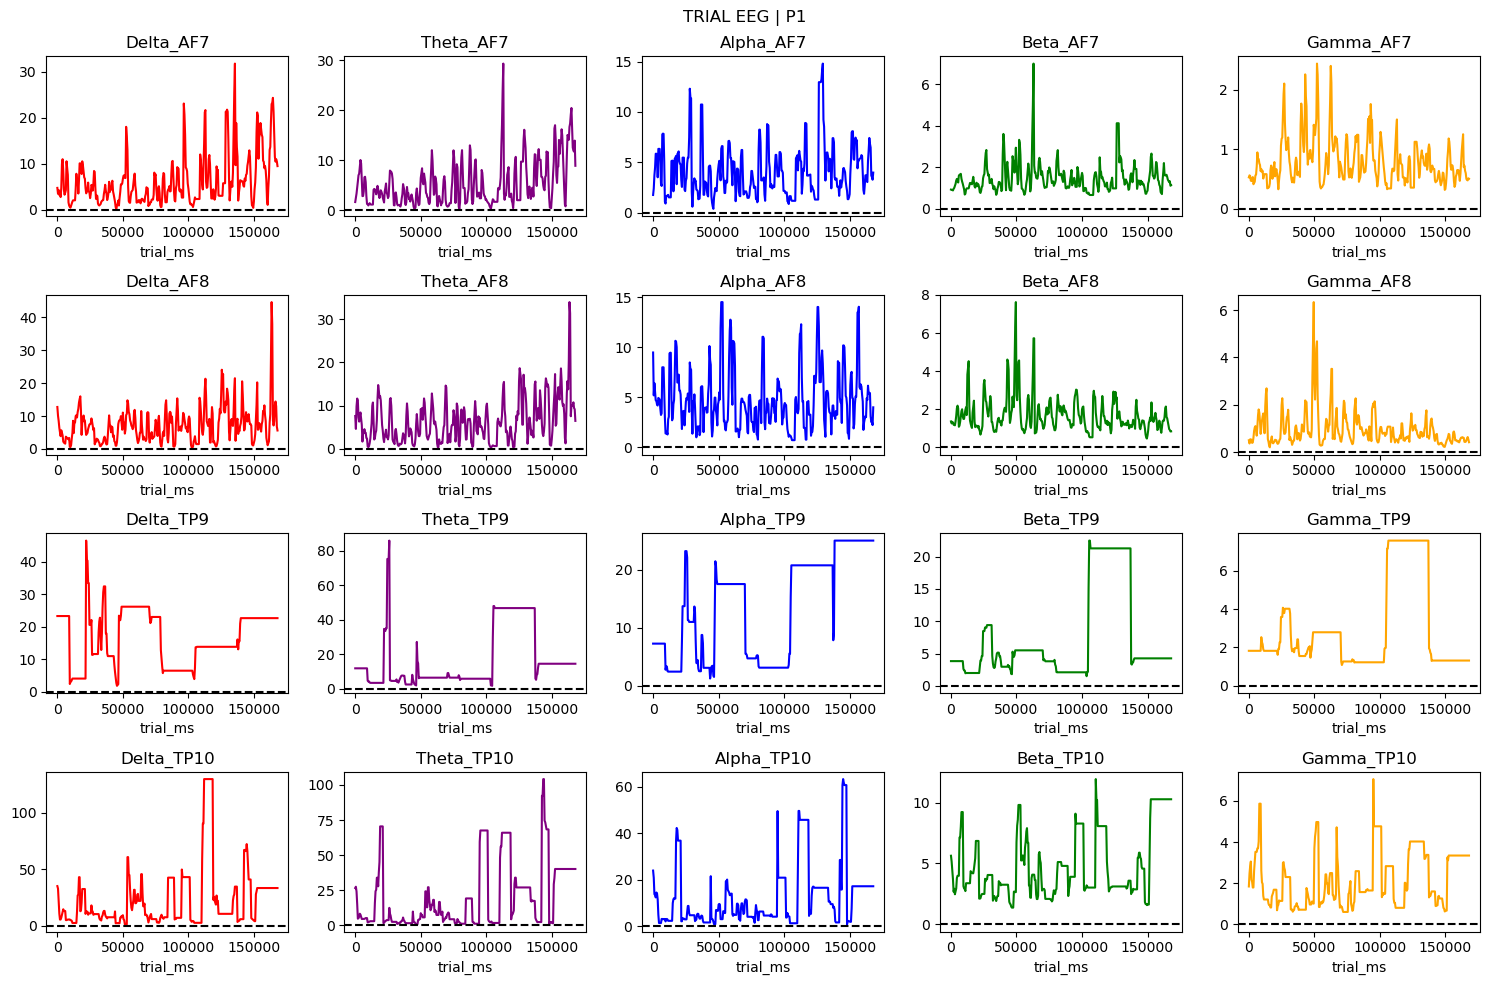

---

### P2

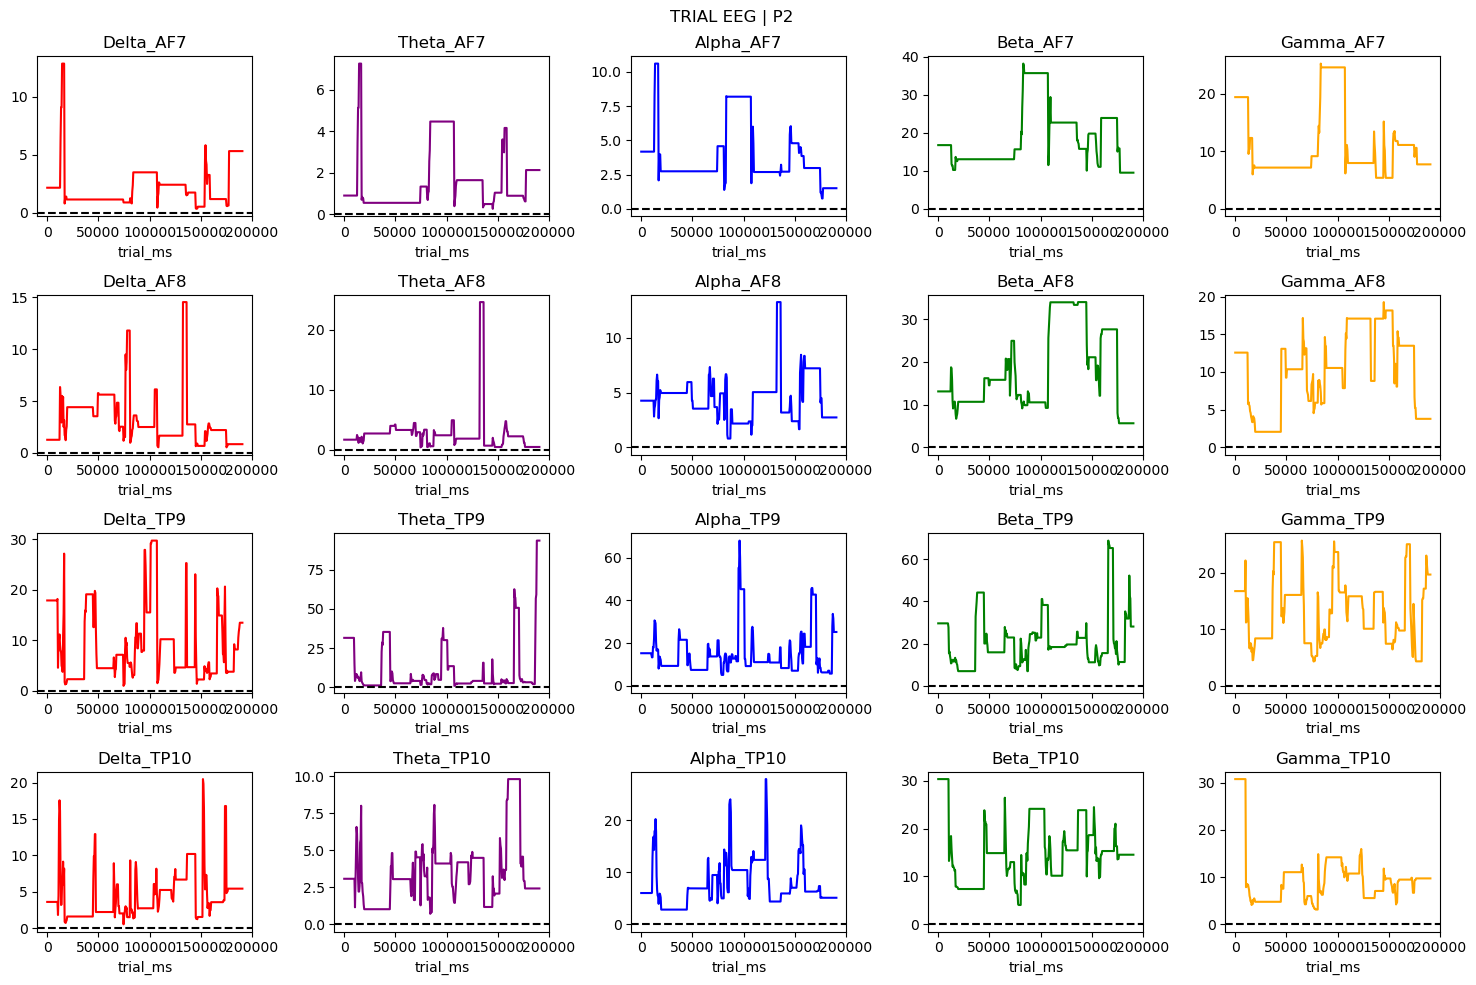

---

### P3

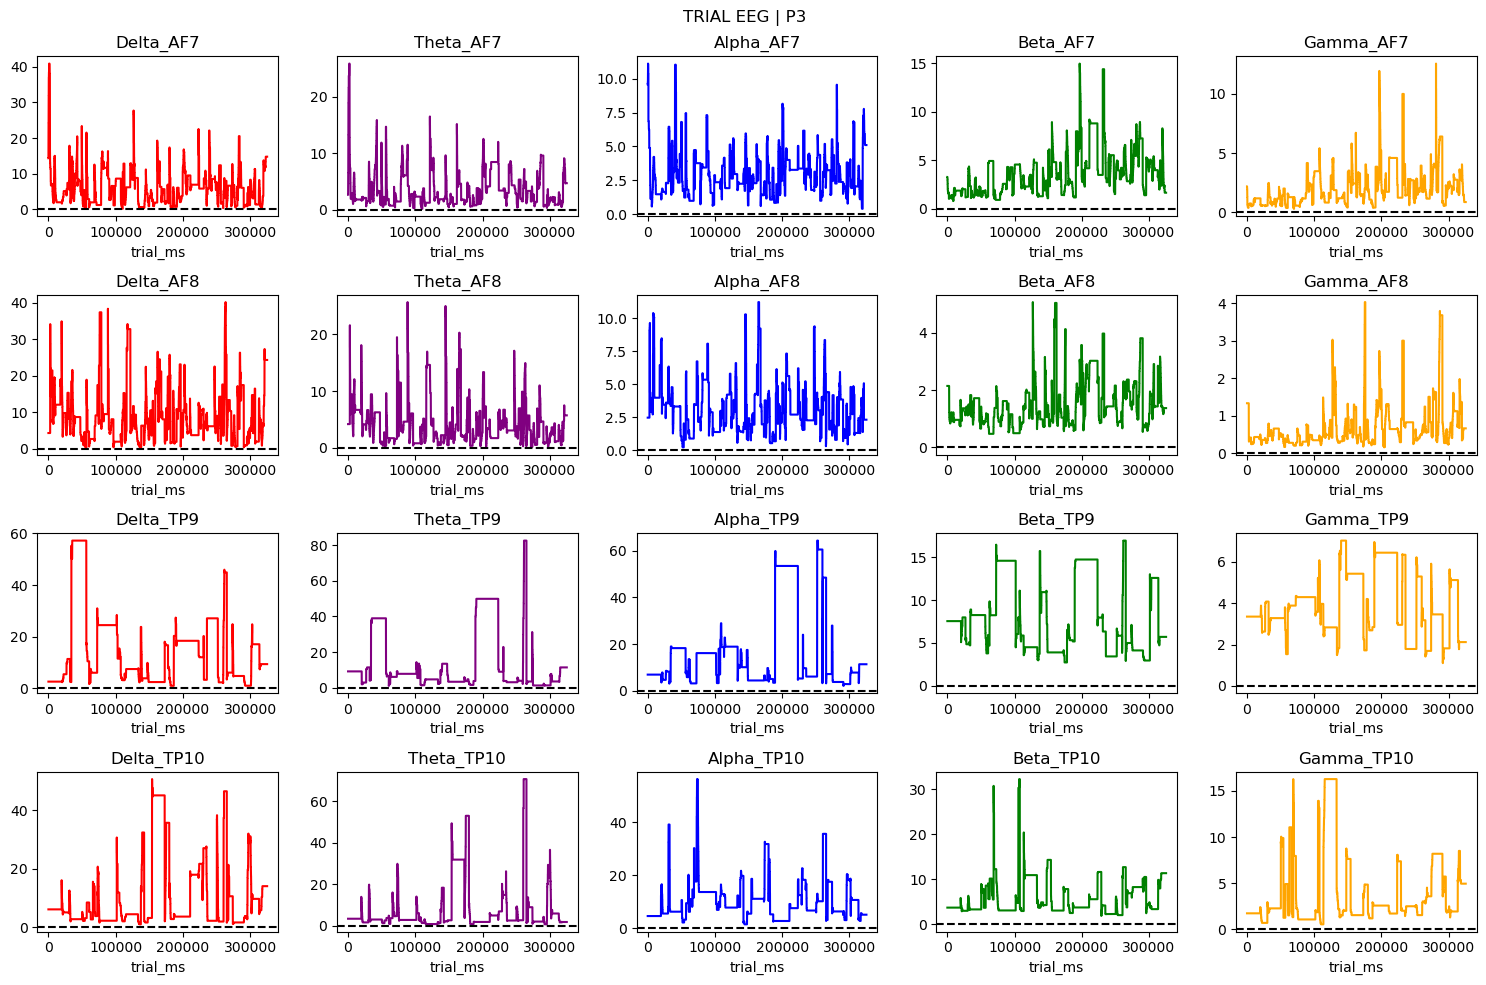

---

### P4

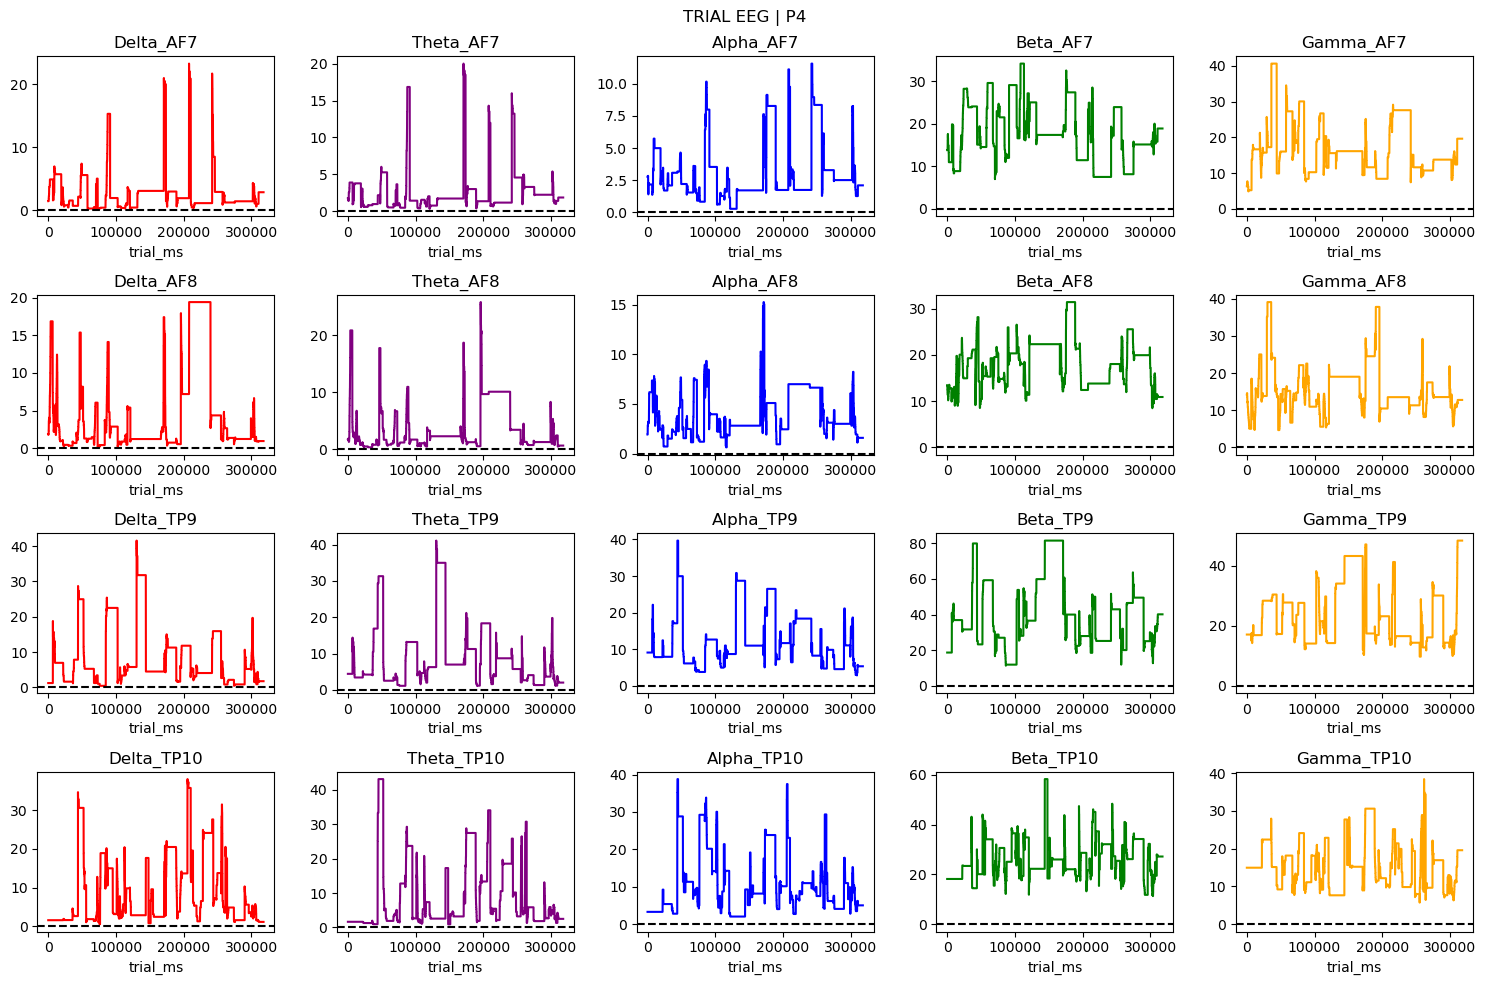

---

### P5

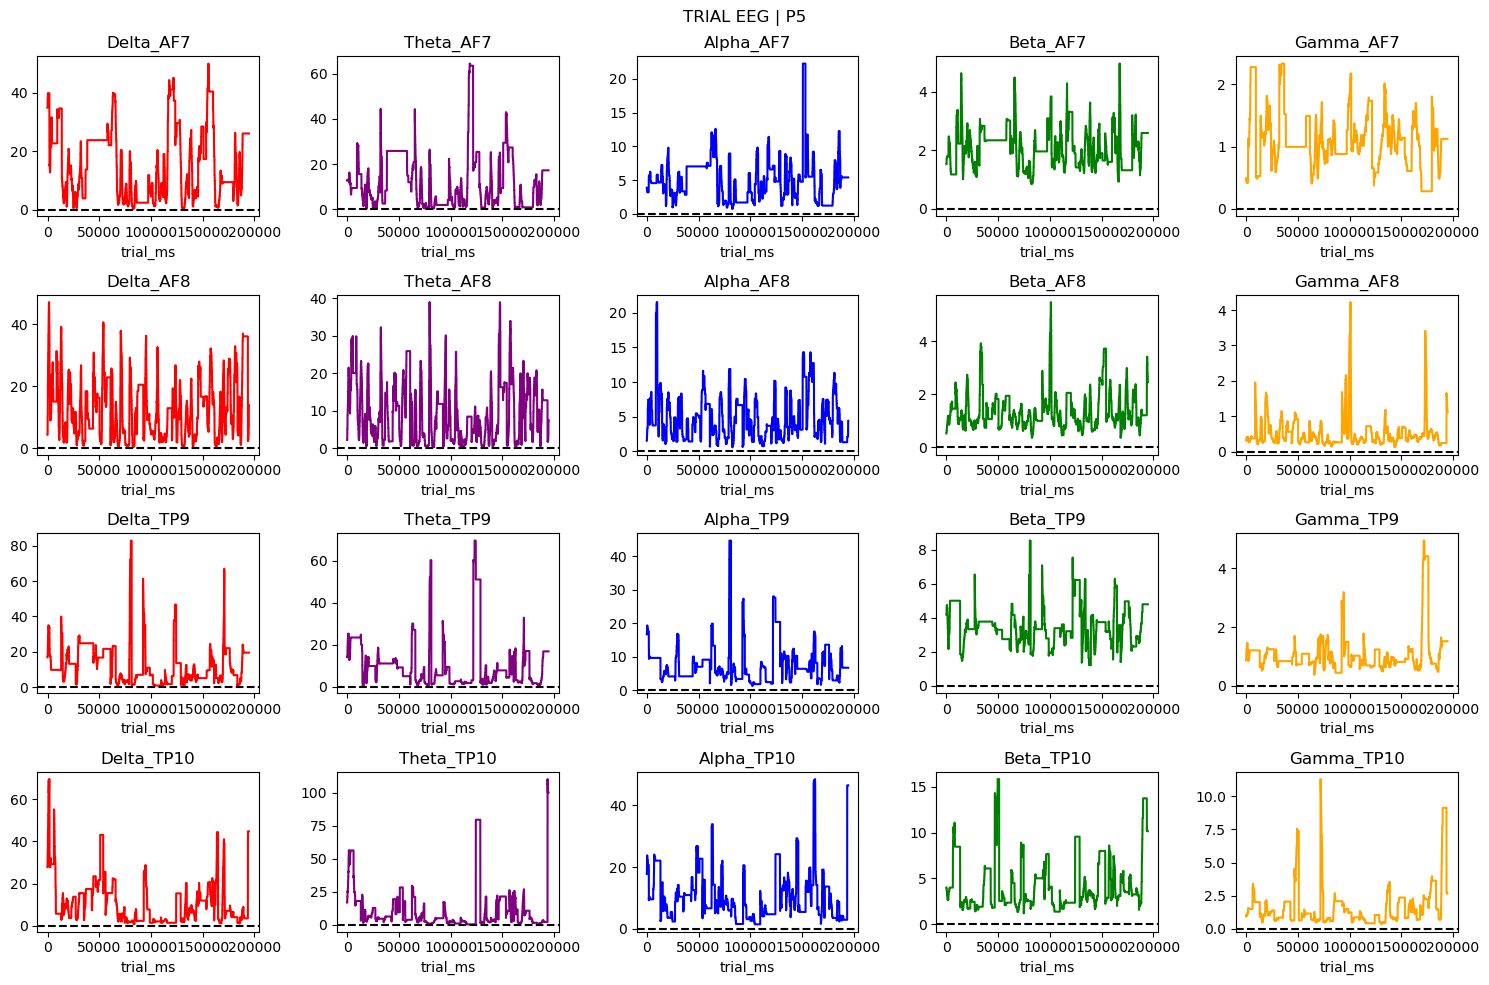

---

### P6

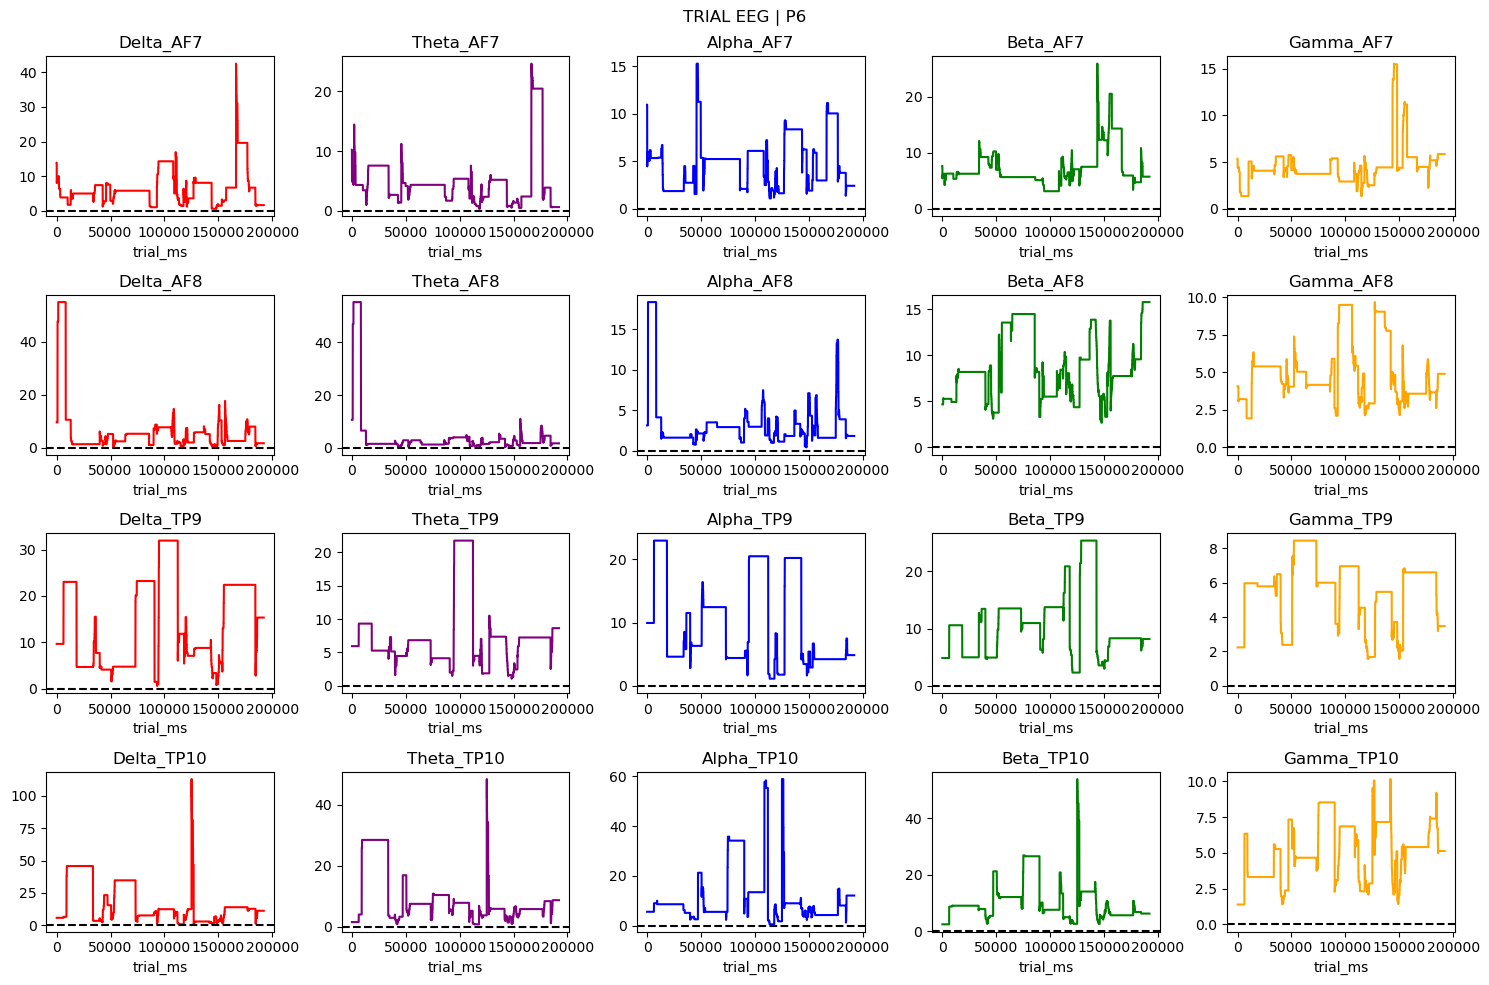

---

In [5]:
for pid in trial_files:
    IDisplay(Markdown(f'### {pid}'))
    trial_dir = os.path.join(_DATA_DIR, pid)

    fig, ax = plt.subplots(nrows=4, ncols=5)
    fig.set_figheight(10)
    fig.set_figwidth(15)
    fig.suptitle(f"TRIAL EEG | {pid}")
    participant_trial_eegs = all_trial_eegs[all_trial_eegs['participant'] == pid]

    for i in range(len(_FREQUENCY_BANDS)):
        freq = _FREQUENCY_BANDS[i]
        color = _FREQUENCY_COLORS[i]
        for j in range(len(_ELECTRODE_CHANNELS)):
            electrode = _ELECTRODE_CHANNELS[j]
            colname = f"{freq}_{electrode}"
            this_trial_ax = participant_trial_eegs.plot.line(x='trial_ms',y=colname, ax=ax[j,i], color=color, title=colname)
            this_trial_ax.legend_ = None
            this_trial_ax.axhline(y=0, color='black', linestyle='--')

    plt.tight_layout()
    plt_savename = os.path.join(_OUTPUT_DIR, f'{pid}_eeg.png')
    plt.savefig(plt_savename, bbox_inches="tight", pad_inches=0.1,)
    plt.show()
    IDisplay(Markdown('---'))

# Final Participants List:

* **P1**, **P3**, and **P5** are valid for EEG analysis
* ~~P2~~, ~~P4~~, and ~~P6~~ are invalid for EEG analysis